<a href="https://colab.research.google.com/github/FNS-Division/geopython-2025/blob/main/0_eda_standardization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICT infrastructure data exploratory analysis

Welcome to this hands-on session where we'll learn how to analyze infrastructure data using Python. We'll be working with real data to understand how to obtain, process and prepare different layers of infrastructure data. This tutorial will teach you how to handle geographic data, create visualizations for exploratory data analysis, and standardize infrastructure data for analysis.

## Setting up our environment

We start by importing the Python libraries we'll need for our analysis:
- geopandas and shapely: For handling geographic data and operations
- pandas: For data manipulation and analysis
- matplotlib and contextily: For creating visualizations and adding map backgrounds
- osmnx: For accessing OpenStreetMap data
- Other utility libraries for various tasks like generating UUIDs and handling country codes

In [1]:
!pip install osmnx contextily summarytools pycountry s3fs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2025.2.0 which is incompatible.
torch 2.5.1+cu124

In [2]:
# Standard library imports
import os
import math

# Data manipulation and analysis
import pandas as pd
import numpy as np
import uuid
import s3fs

# Geospatial libraries
import geopandas as gpd
import osmnx as ox
from shapely.ops import unary_union
import pycountry

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import contextily as cx
import folium

# Interactive tools and display
import ipywidgets as widgets
from IPython.display import display, HTML
from summarytools import dfSummary

We set `fetch_data = False` to use pre-downloaded data instead of fetching it live during the tutorial.

In [3]:
fetch_data = True

The option `display_folium` controls whether to display interactive maps, which can be heavy and prevent the markdown file from displaying correctly.

In [4]:
display_folium = True

## Get country boundaries

Before analyzing infrastructure within our selected country, we need to define the country's boundaries. We:
1. Load a GeoJSON file containing global UN-recognized country boundaries using geopandas
2. Filter to get just the conuntry boundary
3. Calculate the country's bounding box and UTM projection zone for later use
4. Get the ISO3 country code for standardization

This boundary data will be crucial for clipping our infrastructure data and ensuring we're analyzing points within the country's borders.

In [5]:
if fetch_data:
    un_boundaries = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/country_boundary_data/boundaries.geojson")
    stp = un_boundaries[un_boundaries.romnam == "Sao Tome and Principe"]
else:
    stp = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/stp/raw/stp.geojson")

<Axes: >

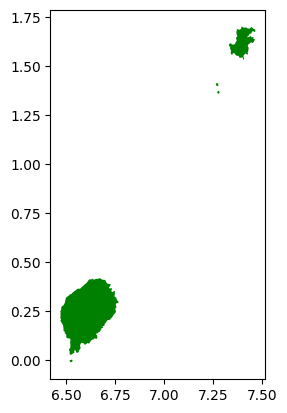

In [6]:
stp.plot(color="green")

In [7]:
boundary = stp.total_bounds
utm = stp.estimate_utm_crs()
latitude = stp.centroid.y.squeeze()

<ipython-input-7-52cfc91c4d8c>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = stp.centroid.y.squeeze()


In [8]:
# @title Function
def get_iso3_country_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_3
    except AttributeError:
        return None

In [9]:
iso3 = get_iso3_country_code("Sao Tome and Principe")
print(f"The ISO-3 code is {iso3}")

The ISO-3 code is STP


## Get point of interest (POI) data

<img src="https://wiki.openstreetmap.org/w/images/c/c8/Public-images-osm_logo.png" alt="OpenStreetMap logo" width="20%">

[OpenStreetMap](https://www.openstreetmap.org/) (OSM) is an open-source, community-driven geospatial data project that provides free and editable geographic information at a global scale. Established in 2004, OSM functions as a vast, collaborative mapping database where users contribute data on roads, buildings, land use, natural features, and more, creating a detailed digital representation of the world's infrastructure. Its open data licensing and API access make it highly valuable for applications in GIS analysis, urban planning, transportation modeling, and disaster response.

We can directly **query** OpenStreetMap online to look for schools using an online tool: https://overpass-turbo.eu/s/1XsE.

![osm-query](https://i.ibb.co/drqmqrP/Screenshot-2024-11-12-at-10-36-06.png)

Othwerise, we can also query the OpenStreetMap data using Python code. The code below:
1. Either fetches school data from OpenStreetMap using the `osmnx` API and the `amenity=school` tag (if `fetch_data`=`True`) or loads pre-downloaded data
2. Filters the data to keep only relevant columns (ID, amenity type, city, education level, etc.)
3. Processes the geographical coordinates for each school

This data will help us understand the distribution of educational facilities across the country and identify areas that might be underserved.

In [10]:
if fetch_data:
    place = "Sao Tome and Principe"
    tags = {"amenity": "school"}
    schools_gdf = ox.features_from_place(place, tags)
    schools_gdf = schools_gdf.reset_index(inplace=False)
else:
    schools_gdf = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/stp/raw/schools.geojson")
    schools_gdf = schools_gdf.reset_index(inplace=False)

In [11]:
schools_gdf = schools_gdf.reset_index()[["id","amenity","operator", "geometry"]]

In [35]:
schools_gdf.head()

,id,amenity,operator,geometry
0,5414412968,school,NaN,POINT (6.74243 0.2568)
1,5414454109,school,NaN,POINT (6.74139 0.26025)
2,5414454271,school,NaN,POINT (6.73747 0.24728)
3,5414470818,school,NaN,POINT (6.74336 0.26394)
4,10538793458,school,Universidade de São Tomé e Príncipe,POINT (6.73855 0.34)


<Axes: >

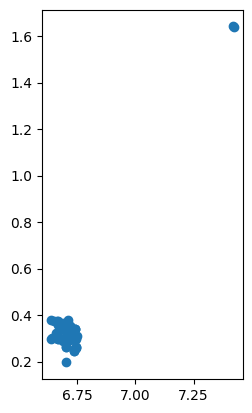

In [38]:
schools_gdf.plot()

## Get Ookla speed test data

<img src="https://i.ibb.co/wcB1JHC/Screenshot-2024-10-25-at-21-24-24.png" alt="Ookla Open Data" width="75%">

[Ookla](https://www.ookla.com/ookla-for-good/open-data), known for its Speedtest platform, offers open data on internet speeds, latency, and network quality worldwide. Their datasets, like the Speedtest Global Index, help researchers analyze internet performance and infer knowledge about infrastructure gaps.

Here, we process their internet speed test data. For both mobile and fixed broadband:
1. We load data from Ookla's public dataset hosted as parquet files on Amazon Web Services (or pre-downloaded files)
2. Filter the data to our geographical bounds obtained earlier
3. Fetch key metrics like average download speed (`avg_d_kbps`) and latency (`avg_lat_ms`)
4. For mobile data, we can also create coverage polygons by buffering around test points. The Ookla data is available as tiles which are approximately 610.8 meters by 610.8 meters at the equator.
Fore more information about processing open data from Ookla, visit their [GitHub](https://github.com/teamookla/ookla-open-data) page.

In [12]:
# @title Function
def get_perf_tiles_parquet_url(service: str, year: int, quarter: int) -> str:
    quarter_start = f"{year}-{(((quarter - 1) * 3) + 1):02}-01"
    url = f"s3://ookla-open-data/parquet/performance/type={service}/year={year}/quarter={quarter}/{quarter_start}_performance_{service}_tiles.parquet"
    return url

### Mobile

In [13]:
if fetch_data:
    mobile_perf_tiles_url = get_perf_tiles_parquet_url("mobile", 2024, 2)
    bbox_filters = [('tile_y', '<=', boundary[3]), ('tile_y', '>=', boundary[1]),
                ('tile_x', '<=', boundary[2]), ('tile_x', '>=', boundary[0])]
    mobile_tiles_df = pd.read_parquet(mobile_perf_tiles_url,
                           filters=bbox_filters,
                           columns=['tile_x', 'tile_y', 'tests', 'avg_d_kbps', 'avg_lat_ms'],
                           storage_options={"s3": {"anon": True}}
                           )
else:
    mobile_tiles_df = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/stp/raw/stp-ookla-mobile-tiles.csv",index_col=0)

In [14]:
mobile_tiles_gdf = gpd.GeoDataFrame(mobile_tiles_df, geometry=gpd.points_from_xy(mobile_tiles_df.tile_x, mobile_tiles_df.tile_y), crs="EPSG:4326").drop(columns=["tile_x", "tile_y"])

In [36]:
mobile_tiles_gdf.head()

,tests,avg_d_kbps,avg_lat_ms,geometry
0,1,7997,227,POINT (7.3801 1.6614)
1,9,4571,193,POINT (7.4185 1.6395)
2,1,26404,18,POINT (6.5561 0.3598)
3,1,135896,19,POINT (6.7099 0.3763)
4,1,77459,18,POINT (6.7154 0.3763)


<Axes: >

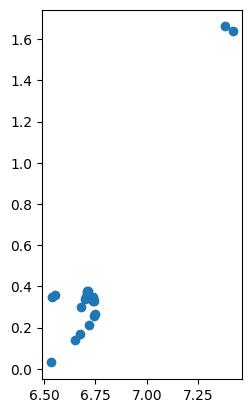

In [39]:
mobile_tiles_gdf.plot()

#### Generate mobile coverage area

We can infer mobile coverage areas from Ookla's internet speed test data. We assume that areas where there have been succesful mobile speed tests are areas that have cellular coverage, and vice versa. We do not have information, however, on which cellular technology it refers to (3G, 4G, 5G).

In [15]:
tile_size_at_latitude=610.8*np.cos(math.radians(latitude))
buffers = mobile_tiles_gdf.to_crs(utm).buffer(tile_size_at_latitude).to_crs("EPSG:4326")
single_polygon = unary_union(buffers)
mobile_coverage_gdf = gpd.GeoDataFrame(geometry=[single_polygon], crs="EPSG:4326")

In [37]:
mobile_coverage_gdf.head()

,geometry,coverage,signal_strength_dbm,operator_name,coverage_id,dataset_id
0,"MULTIPOLYGON (((6.53917 0.02809, 6.53894 0.027...",1,<NA>,<NA>,4d295624-8d6d-4b19-8117-7ab788a38128,e7ebcaa6-5016-4cb5-b689-71de39f9455a


<Axes: >

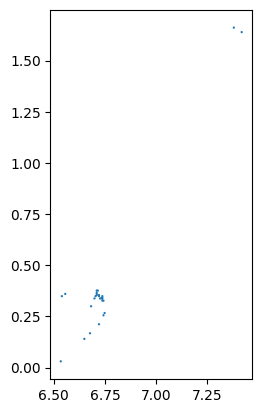

In [40]:
mobile_coverage_gdf.plot()

### Fixed

In [16]:
if fetch_data:
    fixed_perf_tiles_url = get_perf_tiles_parquet_url("fixed", 2024, 2)
    fixed_tiles_df = pd.read_parquet(fixed_perf_tiles_url,
                           filters=bbox_filters,
                           columns=['tile_x', 'tile_y', 'tests', 'avg_d_kbps', 'avg_lat_ms'],
                           storage_options={"s3": {"anon": True}}
                           )
else:
    fixed_tiles_df = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/stp/raw/stp-ookla-fixed-tiles.csv")

In [17]:
fiber_nodes_gdf = gpd.GeoDataFrame(fixed_tiles_df, geometry=gpd.points_from_xy(fixed_tiles_df.tile_x,fixed_tiles_df.tile_y), crs="EPSG:4326")

In [41]:
fiber_nodes_gdf.head()

,tile_x,tile_y,tests,avg_d_kbps,avg_lat_ms,geometry
0,7.3801,1.6779,2,5699,5,POINT (7.3801 1.6779)
1,7.3801,1.6724,1,5953,5,POINT (7.3801 1.6724)
2,7.3856,1.6724,3,511,5,POINT (7.3856 1.6724)
3,7.4130,1.6724,1,27127,6,POINT (7.413 1.6724)
4,7.4130,1.6669,3,2847,27,POINT (7.413 1.6669)


<Axes: >

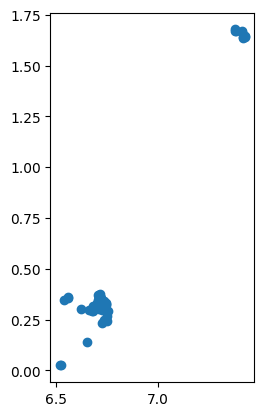

In [42]:
fiber_nodes_gdf.plot()

## Get cell site data

<img src="https://wiki.opencellid.org/images/d/de/OpenCellID_banner_main_page2.png" alt="Ookla Open Data" width="50%">

[OpenCellID](https://wiki.opencellid.org/wiki/What_is_OpenCellID) is the world's largest collaborative community project that collects GPS positions of cell towers, used free of charge, for a multitude of commercial and private purposes. Notably, they publish data on cell site coordinates. In order to download their data, register at their page and obtain a free API acces token. Using this token, you will be able to download [datasets](https://opencellid.org/downloads.php) for each country.

The code below:
1. Loads a CSV file containing cell site coordinates obtained from OpenCellID.
2. Converts it to a GeoDataFrame for spatial analysis

In [18]:
cell_sites = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/stp/raw/stp-cell-sites.csv")

In [19]:
cell_sites_gdf = gpd.GeoDataFrame(cell_sites, geometry=gpd.points_from_xy(cell_sites.lon, cell_sites.lat), crs="EPSG:4326").drop(columns=["lon", "lat"])

In [43]:
cell_sites_gdf.head()

,radio,mcc,net,area,cell,unit,range,samples,changeable,created,updated,averageSignal,geometry
0,UMTS,626,2,1,49126514,201,1000,4,1,1707987926,1711495743,0,POINT (6.7036 0.3815)
1,UMTS,626,2,1,49116615,112,1000,3,1,1707987935,1711495742,0,POINT (6.703 0.3816)
2,LTE,626,1,41,257794,-1,5342,200,1,1707987926,1716450134,0,POINT (6.6718 0.3806)
3,UMTS,626,2,1,49126519,217,1000,20,1,1707988135,1711495743,0,POINT (6.7037 0.3819)
4,UMTS,626,2,1,49126522,217,1000,10,1,1707988205,1711495743,0,POINT (6.7037 0.3822)


<Axes: >

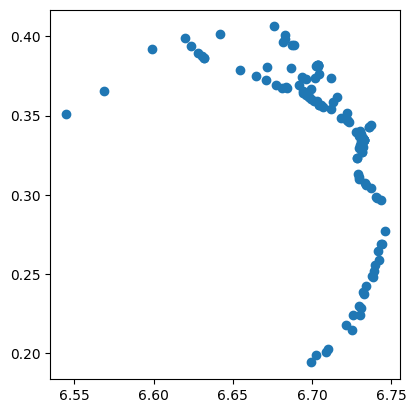

In [44]:
cell_sites_gdf.plot()

# Standardize data

Finally, we standardize all our data into a consistent format, following the [ITU data dictionaries](https://bbmaps.itu.int/geonetwork/srv/eng/catalog.search;jsessionid=4BB00A9A95D58DCCAAD3967DC2DEA0E0#/metadata/d4fce2b9-ed20-4a3e-9312-4f04e1a384ad) for infrastructure data.
1. Create unified schemas for each infrastructure type (POIs, cell sites, nodes, coverage)
2. Generate unique IDs for each feature, using UUIDs (Universally Unique Identifier). These are long serial numbers that are almost guaranteed to be unique every time we generate them.
3. Transform data to match standard schemas
4. Save standardized data to CSV/GeoJSON files

This standardization makes it easier to:
- Share data with other analysts
- Perform consistent analysis across different regions and projects

In [20]:
# @title Function
def extract_lat_lon(gdf, id_column='id'):
   """
   Create a new geodataframe with latitude, longitude and UUID columns
   """
   data = pd.DataFrame({
       id_column: [str(uuid.uuid4()) for _ in range(len(gdf))],
       'dataset_id': str(uuid.uuid4()),
       'lat': gdf.geometry.y,
       'lon': gdf.geometry.x,
   })
   gdf = gpd.GeoDataFrame(data, geometry=gdf.geometry, crs=gdf.crs)
   return gdf

## Point of interest (POI) data

In [21]:
# @title POIs
poi_metadata = pd.DataFrame({
   'column_name': ['poi_id', 'dataset_id', 'lat', 'lon', 'poi_type', 'is_public', 'poi_subtype', 'country_code', 'is_connected', 'connectivity_type'],
   'column_type': ['UUID', 'UUID', 'float', 'float', 'string', 'boolean', 'string', 'string', 'boolean', 'string'],
   'levels': [''] * 10,
   'example': ['123e4567-e89b-12d3-a456-426614174000', '987fcdeb-51a2-12d3-a456-426614174000', '36.7538', '3.0588', 'school', 'True', 'primary school', 'DZA', 'True', '4G'],
   'mandatory': ['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No'],
   'definition': [
       'Unique identifier for the POI',
       'Unique identifier for the dataset',
       'Latitude coordinate',
       'Longitude coordinate',
       'Type of point of interest',
       'Whether the POI is public or private',
       'Specific subtype of the POI',
       'ISO 3166-1 alpha-3 country code',
       'Whether the POI has connectivity',
       'Type of internet connectivity'
   ]
})
styled_df = poi_metadata.style.set_properties(**{
   'text-align': 'left',
   'border': '1px solid black',
   'padding': '8px'
}).set_table_styles([
   {'selector': 'thead', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
   {'selector': 'tbody tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]}
])
display(styled_df)

,column_name,column_type,levels,example,mandatory,definition
0,poi_id,UUID,,123e4567-e89b-12d3-a456-426614174000,Yes,Unique identifier for the POI
1,dataset_id,UUID,,987fcdeb-51a2-12d3-a456-426614174000,Yes,Unique identifier for the dataset
2,lat,float,,36.7538,Yes,Latitude coordinate
3,lon,float,,3.0588,Yes,Longitude coordinate
4,poi_type,string,,school,Yes,Type of point of interest
5,is_public,boolean,,True,No,Whether the POI is public or private
6,poi_subtype,string,,primary school,No,Specific subtype of the POI
7,country_code,string,,DZA,Yes,ISO 3166-1 alpha-3 country code
8,is_connected,boolean,,True,No,Whether the POI has connectivity
9,connectivity_type,string,,4G,No,Type of internet connectivity


In [22]:
# Convert geometries to centroids
schools_gdf.geometry = schools_gdf.geometry.centroid

# Create blank dataframe with id, latitute and longitude columns
formatted_schools = extract_lat_lon(schools_gdf, id_column='poi_id')

# Fill in other columns
formatted_schools["country_code"] = iso3
formatted_schools["poi_type"] = "school"
formatted_schools["is_connected"] = False

<ipython-input-22-c3c135d155b1>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  schools_gdf.geometry = schools_gdf.geometry.centroid


In [23]:
formatted_schools.head()

,poi_id,dataset_id,lat,lon,geometry,country_code,poi_type,is_connected
0,01f9bbf7-716f-401c-b866-fc2e5fbad30a,49070347-e499-406e-9232-350ed292cd2f,0.256797,6.742431,POINT (6.74243 0.2568),STP,school,False
1,b0172b07-d433-4a1d-ac04-105ac339ed8c,49070347-e499-406e-9232-350ed292cd2f,0.260252,6.741389,POINT (6.74139 0.26025),STP,school,False
2,705a61f3-11ce-4298-888a-85d1a39878c8,49070347-e499-406e-9232-350ed292cd2f,0.247277,6.737467,POINT (6.73747 0.24728),STP,school,False
3,9dd53bb8-cada-4b32-9b22-0159f65b0ae9,49070347-e499-406e-9232-350ed292cd2f,0.263945,6.743357,POINT (6.74336 0.26394),STP,school,False
4,7f0eaa66-32cf-4218-a5e2-6f33dfe3c332,49070347-e499-406e-9232-350ed292cd2f,0.339996,6.738550,POINT (6.73855 0.34),STP,school,False


## Cell site data

In [24]:
# @title Cell sites
cell_metadata = pd.DataFrame({
   'column_name': ['ict_id', 'dataset_id', 'latitude', 'longitude', 'operator_name', 'radio_type', 'antenna_height_m', 'backhaul_type', 'backhaul_throughput_mbps'],
   'column_type': ['UUID', 'UUID', 'float', 'float', 'string', 'string', 'float', 'string', 'float'],
   'levels': [
       '',  # ict_id
       '',  # dataset_id
       '',  # latitude
       '',  # longitude
       '',  # operator_name
       'LTE, UMTS, GSM, CDMA',  # radio_type
       '',  # antenna_height_m
       'fiber, microwave, satellite',  # backhaul_type
       ''   # backhaul_throughput_mbps
   ],
   'example': ['123e4567-e89b-12d3-a456-426614174000', '987fcdeb-51a2-12d3-a456-426614174000', '38.988755', '1.401938', 'TelOperator', 'LTE', '25', 'fiber', '1000'],
   'mandatory': ['Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No'],
   'definition': [
       'Cell tower identifier',
       'Unique identifier for the dataset',
       'Cell tower geographical latitude',
       'Cell tower geographical longitude',
       'Mobile network operator name',
       'Type of radio transmission technology',
       'Antenna height on the tower or building',
       'Type of backhaul connectivity of the cell tower',
       'Equipped throughput of the backhaul'
   ]
})
styled_df = cell_metadata.style.set_properties(**{
   'text-align': 'left',
   'border': '1px solid black',
   'padding': '8px'
}).set_table_styles([
   {'selector': 'thead', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
   {'selector': 'tbody tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]}
])
display(styled_df)

,column_name,column_type,levels,example,mandatory,definition
0,ict_id,UUID,,123e4567-e89b-12d3-a456-426614174000,Yes,Cell tower identifier
1,dataset_id,UUID,,987fcdeb-51a2-12d3-a456-426614174000,Yes,Unique identifier for the dataset
2,latitude,float,,38.988755,Yes,Cell tower geographical latitude
3,longitude,float,,1.401938,Yes,Cell tower geographical longitude
4,operator_name,string,,TelOperator,No,Mobile network operator name
5,radio_type,string,"LTE, UMTS, GSM, CDMA",LTE,Yes,Type of radio transmission technology
6,antenna_height_m,float,,25,Yes,Antenna height on the tower or building
7,backhaul_type,string,"fiber, microwave, satellite",fiber,No,Type of backhaul connectivity of the cell tower
8,backhaul_throughput_mbps,float,,1000,No,Equipped throughput of the backhaul


In [25]:
cell_sites_gdf["radio"].value_counts()

,count
radio,
UMTS,78
LTE,31
GSM,8


We assume that each antenna height is 25 meters.

In [26]:
# Create blank dataframe with id, latitute and longitude columns
formatted_cell_sites = extract_lat_lon(cell_sites_gdf, id_column='ict_id')

# Fill in other columns
formatted_cell_sites["radio_type"] = cell_sites_gdf["radio"]
formatted_cell_sites["antenna_height_m"] = 25
formatted_cell_sites["backhaul_type"] = pd.NA
formatted_cell_sites["backhaul_throughput_mbps"] = pd.NA
formatted_cell_sites["operator_name"] = pd.NA

In [27]:
formatted_cell_sites.head()

,ict_id,dataset_id,lat,lon,geometry,radio_type,antenna_height_m,backhaul_type,backhaul_throughput_mbps,operator_name
0,b81f66d0-faa5-4184-8ca5-5a7d67f8dd50,2d5314ee-fd20-4ce9-ba5f-a384146b3b30,0.3815,6.7036,POINT (6.7036 0.3815),UMTS,25,<NA>,<NA>,<NA>
1,b7922333-7150-4f79-a51a-932be7c8af03,2d5314ee-fd20-4ce9-ba5f-a384146b3b30,0.3816,6.7030,POINT (6.703 0.3816),UMTS,25,<NA>,<NA>,<NA>
2,a932d292-8487-4b47-b6bd-cf2bb51714a6,2d5314ee-fd20-4ce9-ba5f-a384146b3b30,0.3806,6.6718,POINT (6.6718 0.3806),LTE,25,<NA>,<NA>,<NA>
3,b1ba5d47-6696-4267-b025-bd2fb9af597d,2d5314ee-fd20-4ce9-ba5f-a384146b3b30,0.3819,6.7037,POINT (6.7037 0.3819),UMTS,25,<NA>,<NA>,<NA>
4,4043dd56-bbc9-43b5-bd2b-e9256a17f48b,2d5314ee-fd20-4ce9-ba5f-a384146b3b30,0.3822,6.7037,POINT (6.7037 0.3822),UMTS,25,<NA>,<NA>,<NA>


## Transmission node data

In [28]:
# @title Nodes
node_metadata = pd.DataFrame({
   'column_name': ['ict_id', 'dataset_id', 'latitude', 'longitude', 'operator_name', 'infrastructure_type', 'node_status', 'equipped_capacity_mbps', 'potential_capacity_mbps'],
   'column_type': ['UUID', 'UUID', 'float', 'float', 'string', 'string', 'string', 'float', 'float'],
   'levels': [
       '',  # node_id
       '',  # dataset_id
       '',  # latitude
       '',  # longitude
       '',  # operator_name
       'fiber, microwave, other',  # infrastructure_type
       'operational, planned, under construction',  # node_status
       '',  # equipped_capacity_mbps
       ''   # potential_capacity_mbps
   ],
   'example': ['123e4567-e89b-12d3-a456-426614174000', '987fcdeb-51a2-12d3-a456-426614174000', '38.988755', '1.401938', 'TelOperator', 'fiber', 'operational', '1000', '2000'],
   'mandatory': ['Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No'],
   'definition': [
       'Node identifier',
       'Unique identifier for the dataset',
       'Geographical latitude',
       'Geographical longitude',
       'Name of the mobile operator',
       'Type of Infrastructure',
       'Status of the node',
       'Equipped bandwidth ready for use to connect subscribers',
       'Total theoretical bandwidth available for subscriber connections'
   ]
})

styled_df = node_metadata.style.set_properties(**{
   'text-align': 'left',
   'border': '1px solid black',
   'padding': '8px'
}).set_table_styles([
   {'selector': 'thead', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
   {'selector': 'tbody tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]}
])
display(styled_df)

,column_name,column_type,levels,example,mandatory,definition
0,ict_id,UUID,,123e4567-e89b-12d3-a456-426614174000,Yes,Node identifier
1,dataset_id,UUID,,987fcdeb-51a2-12d3-a456-426614174000,Yes,Unique identifier for the dataset
2,latitude,float,,38.988755,Yes,Geographical latitude
3,longitude,float,,1.401938,Yes,Geographical longitude
4,operator_name,string,,TelOperator,No,Name of the mobile operator
5,infrastructure_type,string,"fiber, microwave, other",fiber,Yes,Type of Infrastructure
6,node_status,string,"operational, planned, under construction",operational,Yes,Status of the node
7,equipped_capacity_mbps,float,,1000,No,Equipped bandwidth ready for use to connect subscribers
8,potential_capacity_mbps,float,,2000,No,Total theoretical bandwidth available for subscriber connections


All our points are fiber nodes, and we assume that they are all operational.

In [29]:
# Create blank dataframe with id, latitute and longitude columns
formatted_nodes = extract_lat_lon(fiber_nodes_gdf, id_column='ict_id')

# Fill in other columns
formatted_nodes["operator_name"] = pd.NA
formatted_nodes["infrastructure_type"] = "fiber"
formatted_nodes["node_status"] = "operational"
formatted_nodes["equipped_capacity_mbps"] = pd.NA
formatted_nodes["potential_capacity_mbps"] = pd.NA

In [30]:
formatted_nodes.head()

,ict_id,dataset_id,lat,lon,geometry,operator_name,infrastructure_type,node_status,equipped_capacity_mbps,potential_capacity_mbps
0,6fe37fa8-4d3c-4778-a4b2-7f3605a85f85,fa0d28c4-7482-4036-bed1-4784a1af7f75,1.6779,7.3801,POINT (7.3801 1.6779),<NA>,fiber,operational,<NA>,<NA>
1,ea416e9e-a593-4a55-8e8a-154e94d4ecbd,fa0d28c4-7482-4036-bed1-4784a1af7f75,1.6724,7.3801,POINT (7.3801 1.6724),<NA>,fiber,operational,<NA>,<NA>
2,7ebc8fe7-669f-4b96-b3de-49afdf6a799f,fa0d28c4-7482-4036-bed1-4784a1af7f75,1.6724,7.3856,POINT (7.3856 1.6724),<NA>,fiber,operational,<NA>,<NA>
3,c8dc21bc-3183-4a13-a784-491c43fcb7f8,fa0d28c4-7482-4036-bed1-4784a1af7f75,1.6724,7.4130,POINT (7.413 1.6724),<NA>,fiber,operational,<NA>,<NA>
4,17d33919-a5b4-4189-ad60-e73a190f01f8,fa0d28c4-7482-4036-bed1-4784a1af7f75,1.6669,7.4130,POINT (7.413 1.6669),<NA>,fiber,operational,<NA>,<NA>


## Mobile coverage

In [31]:
# @title Coverage
coverage_metadata = pd.DataFrame({
   'column_name': ['coverage_id', 'dataset_id', 'signal_strength_dbm', 'operator_name', 'geometry', 'coverage'],
   'column_type': ['UUID', 'UUID', 'float', 'string', 'geometry', 'integer'],
   'levels': [
       '',  # coverage_id
       '',  # dataset_id
       '',  # signal_strength
       '',  # operator_name
       'polygon',  # geometry
       '1'
   ],
   'example': [
       '123e4567-e89b-12d3-a456-426614174000',
       '987fcdeb-51a2-12d3-a456-426614174000',
       '-93',
       'TelOperator',
       'POLYGON((...))',
       '1'
   ],
   'mandatory': ['Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes'],
   'definition': [
       'Unique identifier for the coverage area',
       'Unique identifier for the dataset',
       'Mobile signal strength in dBm for coverage',
       'Name of the mobile operator',
       'Polygon geometry of coverage area',
       'Binary value indicating coverage'
   ]
})

styled_df = coverage_metadata.style.set_properties(**{
   'text-align': 'left',
   'border': '1px solid black',
   'padding': '8px'
}).set_table_styles([
   {'selector': 'thead', 'props': [('background-color', '#f2f2f2'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
   {'selector': 'tbody tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]}
])
display(styled_df)

,column_name,column_type,levels,example,mandatory,definition
0,coverage_id,UUID,,123e4567-e89b-12d3-a456-426614174000,Yes,Unique identifier for the coverage area
1,dataset_id,UUID,,987fcdeb-51a2-12d3-a456-426614174000,Yes,Unique identifier for the dataset
2,signal_strength_dbm,float,,-93,Yes,Mobile signal strength in dBm for coverage
3,operator_name,string,,TelOperator,No,Name of the mobile operator
4,geometry,geometry,polygon,POLYGON((...)),Yes,Polygon geometry of coverage area
5,coverage,integer,1,1,Yes,Binary value indicating coverage


In [32]:
# Create blank dataframe with id, latitute and longitude columns
formatted_coverage = mobile_coverage_gdf

# Fill in other columns
formatted_coverage["coverage"] = 1
formatted_coverage["signal_strength_dbm"] = pd.NA
formatted_coverage["operator_name"] = pd.NA
formatted_coverage["coverage_id"] = [str(uuid.uuid4()) for _ in range(len(formatted_coverage))]
formatted_coverage["dataset_id"] = str(uuid.uuid4())

In [33]:
formatted_coverage.head()

,geometry,coverage,signal_strength_dbm,operator_name,coverage_id,dataset_id
0,"MULTIPOLYGON (((6.53917 0.02809, 6.53894 0.027...",1,<NA>,<NA>,4d295624-8d6d-4b19-8117-7ab788a38128,e7ebcaa6-5016-4cb5-b689-71de39f9455a
